## Image3Pipeline   (MIRI CALIMAGE3)

`Image3Pipeline` combines the calibrated data from multiple exposures (e.g. a dither or mosaic pattern) into a single rectified (distortion corrected) product. Before being combined, the exposures receive additional corrections for the purpose of astrometric alignment, background matching, and outlier rejection. 

Official documentation for `Image3Pipeline` can be found here:

<https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image3.html>

The `Image3Pipeline` comprises a linear series of steps. The steps applied to MIRI data in order are:

|Step|Description|
|:---|:---|
|`tweakreg`|refine the WCS solution by comparing source catalogues from input images|
|`skymatch`|compute sky values in a collection of input images that contain both sky and source signal|
|`outlier_detection`|identification of bad pixels or cosmic-rays that remain in each of the input images|
|`resample`|resample using WCS and distortion information into an undistorted product|
|`source_catalog`|resample using WCS and distortion information into an undistorted product|


### Input data

An example of running the file through the `Image3Pipeline` is now shown using a simple simulated 4-point dither observation of a galaxy with the MIRI Imager (F1130W filter) produced with [MIRISim v2.3](https://wiki.miricle.org/Public/MIRISim_Public) and brought to level 2B using the `Detector1Pipeline` and `Image2Pipeline` modules. 

### Python

Start by importing what will be used and set the `CRDS_CONTEXT`

In [1]:
# imports
import os, glob, shutil
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call
from jwst import datamodels
from jwst.associations.lib.member import Member
from jwst.associations.asn_from_list import asn_from_list
from astropy.table import Table
from photutils import CircularAperture

# set the CRDS_CONTEXT
os.environ["CRDS_CONTEXT"] = "jwst_0641.pmap"

`Image3Pipeline` requires an association file as input that lists the exposures to be combined. The content of the association file is printed for inspection. It is assumed the files are in 'IMA_science'

In [2]:
# load the science and background files to lists
my_science_files = glob.glob('IMA_science/*cal.fits')
my_science_files = sorted(my_science_files)

# set the association name
asn_name = 'my_galaxy'

# create an association
asn = asn_from_list(my_science_files, product_name=asn_name)

# set some metadata
asn['asn_pool'] = asn_name + '_pool'
asn['asn_type'] = 'image3'
        
# print the association and save to file
name, ser = asn.dump()
print(ser)

asn_file = asn_name + '_lvl3_asn.json'
with open(asn_file, 'w') as f:
    f.write(ser)

{
    "asn_type": "image3",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "0.17.1",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "my_galaxy_pool",
    "products": [
        {
            "name": "my_galaxy",
            "members": [
                {
                    "expname": "IMA_science/my_galaxy_dither1_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither2_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither3_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither4_cal.fits",
                    "exptype": "science

Import Image2Pipeline and print the docstring to show some information

In [3]:
from jwst.pipeline import Image3Pipeline
print(Image3Pipeline.__doc__)


    Image3Pipeline: Applies level 3 processing to imaging-mode data from
                    any JWST instrument.

    Included steps are:
        assign_mtwcs
        tweakreg
        skymatch
        outlier_detection
        resample
        source_catalog
    


The association file is passed as input. The output level 2B files will be saved in `my_output_dir` as `_cal.fits`. 

*Parameters used:*
    
`save_results`: boolean, optional, default=False  
&nbsp;&nbsp;&nbsp;&nbsp; save the results to file
    
`output_dir` : boolean, optional, default is the working directory   
&nbsp;&nbsp;&nbsp;&nbsp; the location to save the output
    
There are still some issues with the tweakreg step so this is skipped for now. We also set the source detection parameters and explicitly save the output from the `source_catalog` step.


In [8]:
# user specified
my_output_dir = 'demo_output'

# the output directory should be created if it doesn't exist
if not os.path.exists(my_output_dir): 
    os.mkdir(my_output_dir)

# run the pipeline
Image3Pipeline.call(asn_file, save_results=True, output_dir=my_output_dir,
                    steps={'skymatch':{'skip':True},
                           'source_catalog':{'save_results':True, 'kernel_fwhm': 3.0, 'snr_threshold': 5.}})


2020-10-14 14:34:49,784 - stpipe - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

2020-10-14 14:34:50,117 - CRDS - ERROR -  Error determining best reference for 'pars-assignmtwcsstep'  =   Unknown reference type 'pars-assignmtwcsstep'
2020-10-14 14:34:50,264 - CRDS - ERROR -  Error determining best reference for 'pars-tweakregstep'  =   Unknown reference type 'pars-tweakregstep'
2020-10-14 14:34:50,534 - CRDS - ERROR -  Error determining best reference for 'pars-skymatchstep'  =   Unknown reference type 'pars-skymatchstep'
2020-10-14 14:34:50,687 - CRDS - ERROR -  Error determining best reference for 'pars-outlierdetectionstep'  

2020-10-14 14:34:53,655 - stpipe.Image3Pipeline.tweakreg - WARNING - No sources found in my_galaxy_dither4_cal.fits.
2020-10-14 14:34:53,670 - stpipe.Image3Pipeline.tweakreg - INFO - 
2020-10-14 14:34:53,670 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 4.
2020-10-14 14:34:53,671 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:
2020-10-14 14:34:53,719 - stpipe.Image3Pipeline.tweakreg - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/gwcs/wcs.py:973: DeprecationWarning: Indexing a WCS.pipeline step is deprecated. Use the `frame` and `transform` attributes instead.
  warnings.warn("Indexing a WCS.pipeline step is deprecated. "

2020-10-14 14:34:53,719 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'my_galaxy_dither1_cal':
2020-10-14 14:34:53,720 - stpipe.Image3Pipeline.tweakreg - INFO -      my_galaxy_dither1_cal
2020-10-14 14:34:53,761 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in

2020-10-14 14:35:04,538 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /Users/patrickkavanagh/crds_mirror/references/jwst/miri/jwst_miri_drizpars_0001.fits
2020-10-14 14:35:04,647 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for my_galaxy
2020-10-14 14:35:06,026 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)
2020-10-14 14:35:07,078 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)
2020-10-14 14:35:08,165 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)
2020-10-14 14:35:09,313 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)
2020-10-14 14:35:09,880 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021513048 -0.020377659 0.024586201 0.014641639 359.990548179 0.017628679 359.987475025 -0.017390618
2020-10-14 14:35:10,653 - stpipe.Image3Pipeline.resample - INFO - Saved model in demo_output/my_galax

We can plot the before (rate) and after (cal) images for the first dither position

2020-10-14 14:40:37,490 - stpipe - WARNING - /Users/patrickkavanagh/anaconda3/anaconda3/envs/jwst7.6/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



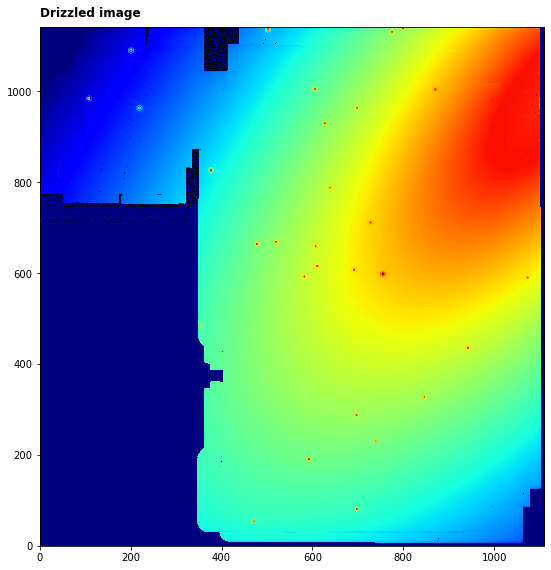

In [14]:
driz_dm = datamodels.open(os.path.join(my_output_dir,'my_galaxy_i2d.fits'))

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=500))
axs.annotate('Drizzled image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()



In [16]:
my_catalog = os.path.join(my_output_dir,'my_galaxy_cat.ecsv')
sources = Table.read(my_catalog, format='ascii.ecsv')

print(sources.columns)    # print all available column names
print()
sources['id', 'xcentroid', 'ycentroid', 'sky_centroid', 'aper30_flux'].pprint(max_width=200)

<TableColumns names=('id','xcentroid','ycentroid','sky_centroid','aper_bkg_flux','aper_bkg_flux_err','aper30_flux','aper30_flux_err','aper50_flux','aper50_flux_err','aper70_flux','aper70_flux_err','aper_total_flux','aper_total_flux_err','aper30_abmag','aper30_abmag_err','aper50_abmag','aper50_abmag_err','aper70_abmag','aper70_abmag_err','aper_total_abmag','aper_total_abmag_err','aper30_vegamag','aper30_vegamag_err','aper50_vegamag','aper50_vegamag_err','aper70_vegamag','aper70_vegamag_err','aper_total_vegamag','aper_total_vegamag_err','CI_30_50','CI_50_70','CI_30_70','is_star','sharpness','roundness','nn_dist','nn_abmag','isophotal_flux','isophotal_flux_err','isophotal_abmag','isophotal_abmag_err','isophotal_vegamag','isophotal_vegamag_err','isophotal_area','semimajor_sigma','semiminor_sigma','ellipticity','orientation','sky_orientation','sky_bbox_ll','sky_bbox_ul','sky_bbox_lr','sky_bbox_ur')>

 id xcentroid ycentroid                 sky_centroid                 aper30_flux 
       pi

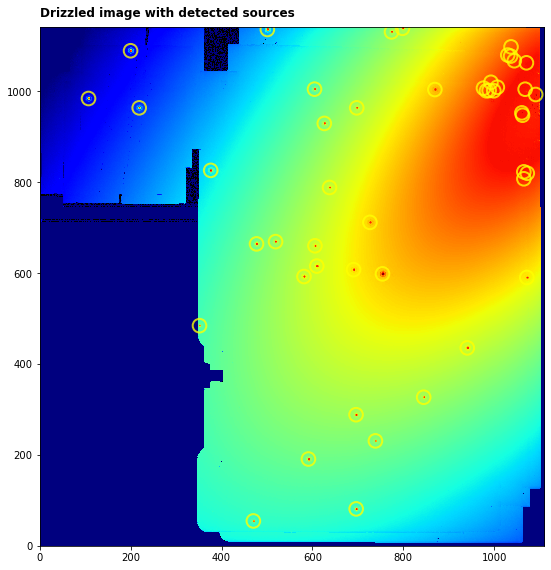

In [18]:
# read source X,Y positions from the table, show with circles of radius 10pix
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=15.)

# plot--------------------------------------
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# show last frame of first integration
axs.imshow(driz_dm.data, cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=10,vmax=500))
apertures.plot(color='yellow', lw=2.0, alpha=0.8)
axs.annotate('Drizzled image with detected sources', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs.set_facecolor('black')

plt.tight_layout()
plt.show()

### Command line

To achieve the same result from the command line there are a couple of options. However, one must still generate the association file. In this case, it is best to copy the template above into a text file and save it to `my_galaxy_lvl3_asn.json`. The content is printed here for convenience.

```python
{
    "asn_type": "image3",
    "asn_rule": "DMS_Level3_Base",
    "version_id": null,
    "code_version": "0.13.7",
    "degraded_status": "No known degraded exposures in association.",
    "program": "noprogram",
    "constraints": "No constraints",
    "asn_id": "a3001",
    "target": "none",
    "asn_pool": "my_galaxy_pool",
    "products": [
        {
            "name": "my_galaxy",
            "members": [
                {
                    "expname": "IMA_science/my_galaxy_dither1_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither2_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither3_cal.fits",
                    "exptype": "science"
                },
                {
                    "expname": "IMA_science/my_galaxy_dither4_cal.fits",
                    "exptype": "science"
                }
            ]
        }
    ]
}
```

**Option 1:**
Run the `Image3Pipeline` class using the `strun` command:

```bash
mkdir demo_output

strun jwst.pipeline.Image3Pipeline my_galaxy_lvl3_asn.json --output_dir demo_output
```

This will produce the same output file in the user-defined `--output_dir`


**Option 2:**
Collect the pipeline configuration files in your working directory (if they are not already there) using `collect_pipeline_configs` and then run the `Image3Pipeline` using the `strun` command with the associated `calwebb_image3.cfg` file. This option is a little more flexible as one can create edit the cfg files, use them again, etc.

```bash
mkdir demo_output

collect_pipeline_cfgs cfgs/

strun cfgs/calwebb_image3.cfg my_galaxy_lvl3_asn.json --output_dir demo_output
```

This will produce the same output file in the user-defined `--output_dir`

### Further examples

Other notebooks with more complex examples can be found here:

*To be added*